# Chapter09 비지도 학습

In [ ]:
import os
import sys
import numpy as np
import pandas as pdㅊ
import matplotlib.pyplot as plt

### 9.1 군집

군집 (clustering) :

샘플들을 비슷한 샘플의 그룹(클러스터)으로 할당하는 비지도 학습 

- k-평균 : 

 각 클러스터의 중심을 찾고 가장 가까운 클러스터에 샘플을 할당한다.

In [ ]:
# 클러스팅 용 가상 데이터 생성
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)
y

array([4, 2, 0, ..., 3, 0, 2])

In [ ]:
# 클러스터 데이터셋 그리는 메서드 정의
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

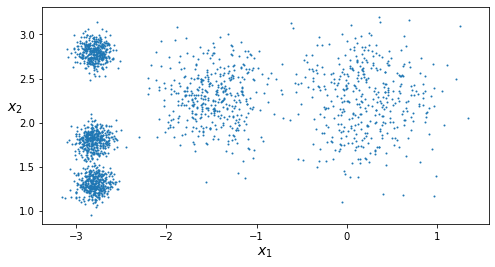

In [ ]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [ ]:
# k-평균 알고리즘 훈련 및 예측
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k)   # n_clusters: 알고리즘이 찾을 클러스트 개수
y_pred = kmeans.fit_predict(X)
y_pred

array([0, 4, 1, ..., 2, 1, 4], dtype=int32)

In [ ]:
kmeans.labels_  # 훈련된 샘플의 레이블이 저장되어 있음

array([0, 4, 1, ..., 2, 1, 4], dtype=int32)

In [ ]:
y_pred is kmeans.labels_

True

In [ ]:
kmeans.cluster_centers_  # KMeans가 찾은 각 클러스터별 센트로이드

array([[-2.80037642,  1.30082566],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80389616,  1.80117999]])

In [ ]:
# 새로운 샘플 예측
X_new = np.array([[0,2], [3,2], [-3,3], [-3,2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

In [ ]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=35, linewidths=12, 
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

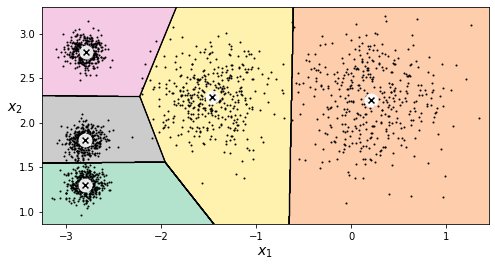

In [ ]:
# 결정경계 그리기 (보로노이 다이어그램)
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

위 그림을 보면, 클러스터의 크기가 달라서 샘플 몇 개는 레이블이 잘못 부여되었다.. (하드 군집)

- 하드 군집 :

 샘플을 하나의 클러스터에 할당하는 것

- 소프트 군집 :
 
 클러스터마다 샘플에 점수를 부여하는 것

In [ ]:
kmeans.transform(X_new)  # 샘플과 각 센트로이드 사이의 거리를 반환

array([[2.88633901, 0.32995317, 2.9042344 , 1.49439034, 2.81093633],
       [5.84236351, 2.80290755, 5.84739223, 4.4759332 , 5.80730058],
       [1.71086031, 3.29399768, 0.29040966, 1.69136631, 1.21475352],
       [1.21567622, 3.21806371, 0.36159148, 1.54808703, 0.72581411]])

k-평균 알고리즘 :

1. 처음에는 센트로이드를 랜덤하게 초기화

2. 각 샘플을 가장 가까운 센트로이드에 할당

3. 센트로이드에 할당된 샘플의 평균으로 센트로이드를 업데이트합니다.

4. 센트로이드 업데이트 변화가 없을 때까지 2~3 반복

In [ ]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=3, n_clusters=5,
       n_init=1, n_jobs=None, precompute_distances='auto', random_state=0,
       tol=0.0001, verbose=0)

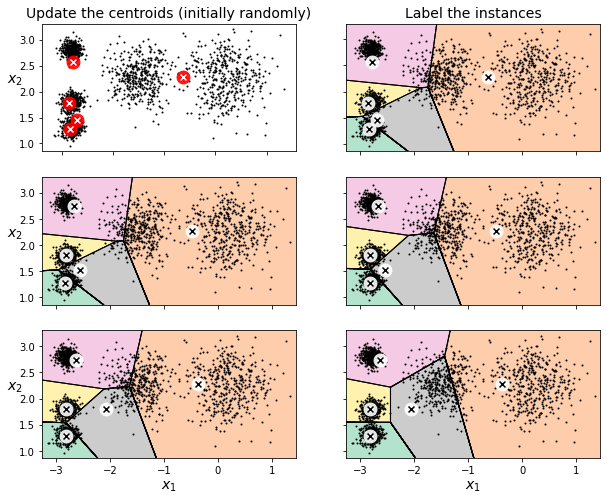

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

In [ ]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

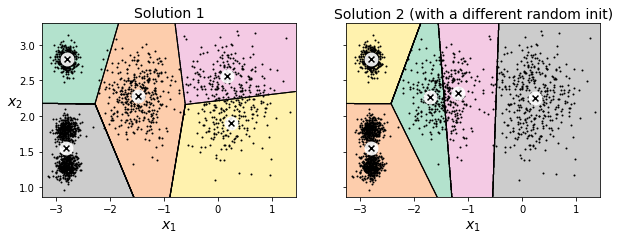

In [ ]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

운 나쁜 센트로이드 초기화 때문에 만들어진 나쁜 군집 예

- 센트로이드 초기화 방법 : 

 1. 먼저 실행한 또 다른 군집 알고리즘의 센트로이드로 초기화하기

 2. 랜덤 초기화를 다르게 하여 여러 번 알고리즘을 실행하고 가장 좋은 솔루션 선택하기

 3. k-평균++ 초기화

In [ ]:
# 1번 방법
good_init = np.array([[-3,3],[-3,2],[-3,1],[-1,2],[0,2]])

# 1번 + 2번 방법
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)   # n_init: 랜덤 초기화 횟수 (default:10)
kmeans.fit_predict(X)

array([2, 1, 4, ..., 0, 4, 1], dtype=int32)

- 이너서 (inertia) : 가장 좋은 솔루션을 선택할 수 있는 성능 지표

 : 각 샘플과 가장 가까운 센트로이드 사이의 평균 제곱 거리

- KMeans는 n_init번 실행하여 '이너셔'가 가장 낮은 모델을 반환한다.

In [ ]:
kmeans.inertia_   # 모델의 이너셔 반환

211.5985372581684

In [ ]:
kmeans.socre(X)  # score()메서드는 이너셔의 음수값을 반환

- k-평균++ 알고리즘 :

 다른 센트로이드와 거리가 먼 센트로이드를 선택하는 초기화 단계를 가짐

 1. 데이터셋에서 무작위로 균등하게 하나의 센트로이드 $c_1$을 선택합니다.

 2. $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$의 확률로 샘플 $\mathbf{x}_i$를 새로운 센트로이드 $c_i$로 선택
 
   - $D(\mathbf{x}_i)$ : 샘플 $\mathbf{x}_i$에서 이미 선택된 가장 가까운 센트로이드까지 거리

 3. $k$ 개의 센트로이드를 선택할 때까지 이전 단계를 반복

KMeans 클래스가 기본적으로 이 초기화 방법을 사용

반복 횟수도 줄여주어서 속도도 빠를 것이다.

- k-평균 속도 개선과 미니배치 k-평균

 목적함수 $J = \sum\limits_{n=1}^{K} \sum\limits_{n=1}^{K}r_{nk} || \mathbf{x}_n - \mu_k||^2$

In [ ]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)